## testing a basic model configuration on the SeaFlow and Zinser datasets and examining the effect of enforcing division

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc', # m=25, delta_v_inv=8
    'zinser':'data/Zinser_SizeDist_regrid-30-15.nc',  # m=30, delta_v_inv=15
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for k in datafiles:
    data_gridded[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_gridded[k][var] = nc.variables[var][:]
    desc[k] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[k])

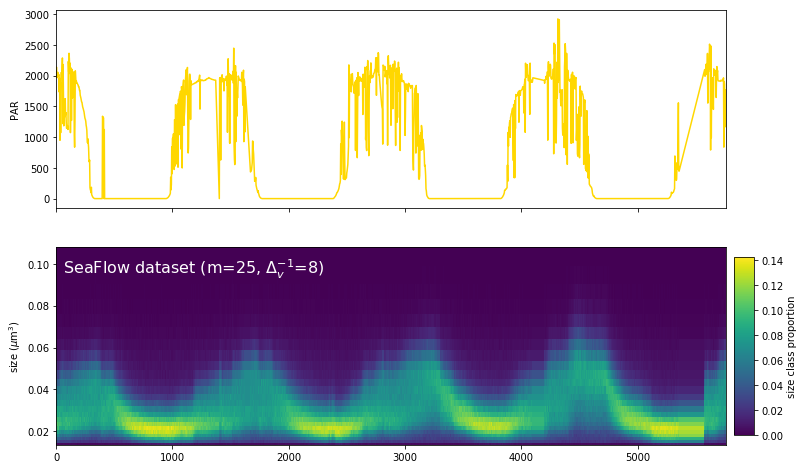

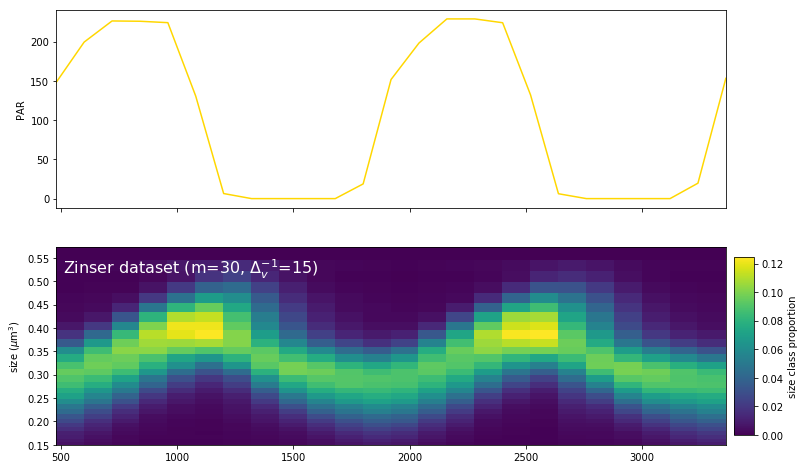

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,k in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.plot(data_gridded[k]['time'], data_gridded[k]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[k]['v_min']
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[k]['time'],v,data_gridded[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [3]:
# prepare data for Stan model

data = {}

for k in data_gridded:
    dt = 20 # in units of minutes
    
    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_gridded[k][v]

    data[k]['obs'] = data_gridded[k]['w_obs']
    data[k]['t_obs'] = data_gridded[k]['time']
    data[k]['E'] = data_gridded[k]['PAR']
    # use first measurements as initial conditions
    data[k]['w_ini'] = data_gridded[k]['w_obs'][:,0]

    # limit the data

    limit_days = 2
    if 'seaflow' in k:
        stride_t_obs = 20
    else:
        stride_t_obs = 1

    # remove very first observations
    ind_obs = data[k]['t_obs'] > 3
    data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
    data[k]['obs'] = data[k]['obs'][:,ind_obs]

    if limit_days > 0:
        limit_minutes = limit_days*1440

        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]

        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    if stride_t_obs > 0:
        data[k]['t_obs'] = data[k]['t_obs'][::stride_t_obs]
        data[k]['obs'] = data[k]['obs'][:,::stride_t_obs]

    data[k]['nt_obs'] = data[k]['obs'].shape[1]

    # finally, add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_gridded[k]['time'], fp=data_gridded[k]['PAR'])

In [4]:
import re
import pystan

modelfiles = {
    'freedelta':'stancode/matrixmodel_freedelta_normparam_trackgrowth.stan',
    #'freedelta_gammai':'stancode/matrixmodel_freedelta_gammai_normparam_trackgrowth.stan',
    #'sigdelta_gammai':'stancode/matrixmodel_sigmoidaldelta_gammai_normparam_trackgrowth.stan',
}
desc_model = {
    'freedelta':'model with "free" deltas',
    'freedelta_gammai':'model with "free" deltas, size-dependent growth',
    'sigdelta_gammai':'model with sigmoidal delta, size-dependent growth',
}


stan_codes = {}
for name in modelfiles:
    with open(modelfiles[name]) as f:
        stan_codes[name] = f.read()
    
for name in modelfiles:
    if 'freedelta' in name:
        name_new = name+'_enforcediv'
        code_split = stan_codes[name].split('\n')
        code_split_new = []
        for line in code_split:
            m = re.match('^( *real).*  *delta_mu',line)
            if m:
                code_split_new.append(m.groups(0)[0]+'<lower=1.0> delta_mu; // enforce division')
            else:
                code_split_new.append(line)
        stan_codes[name_new] = '\n'.join(code_split_new)
        desc_model[name_new] = desc_model[name] + ' with enforced division'
        #print(stan_codes[name_new])
models = {name:pystan.StanModel(model_code=stan_codes[name], model_name=name, obfuscate_model_name=False) for name in stan_codes}
None

INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_enforcediv NOW.


In [5]:
# run a bunch of experiments -- this may take a while

mcmcs = {}
for name in models:
    mcmcs[name] = {}
    for k in data:
        mcmcs[name][k] = models[name].sampling(data=data[k], iter=2000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [6]:
for name in models:
    for k in data:
        print('model: "{}", {}'.format(name, desc[k].split('(')[0]))
        print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x))

model: "freedelta", SeaFlow dataset 
Inference for Stan model: freedelta.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.82    0.01   0.52   1.89   2.46   2.78   3.14   3.91   1254    1.0
delta_sigma         1.49    0.01   0.48   0.82   1.15   1.42   1.73   2.66   1371    1.0
delta_max[1]        0.35  3.7e-3   0.17    0.1   0.23   0.33   0.45   0.74   2095    1.0
delta_max[2]        0.99  4.5e-3    0.2   0.66   0.84   0.96   1.11   1.44   2044    1.0
delta_max[3]        1.45  5.4e-3   0.24   1.01   1.29   1.44   1.59   1.95   1893    1.0
delta_max[4]        1.96  8.6e-3    0.4   1.16   1.67   1.95   2.23   2.78   2192    1.0
delta_max[5]         2.4    0.01   0.52   1.42   2.04    2.4   2.76    3.4   2485    1.0
delta_max[6]        2.87    0.01   0.63   1.68   2.44   2.84   3.26   4.18   2093    1.0
delta_m

## Plot the results

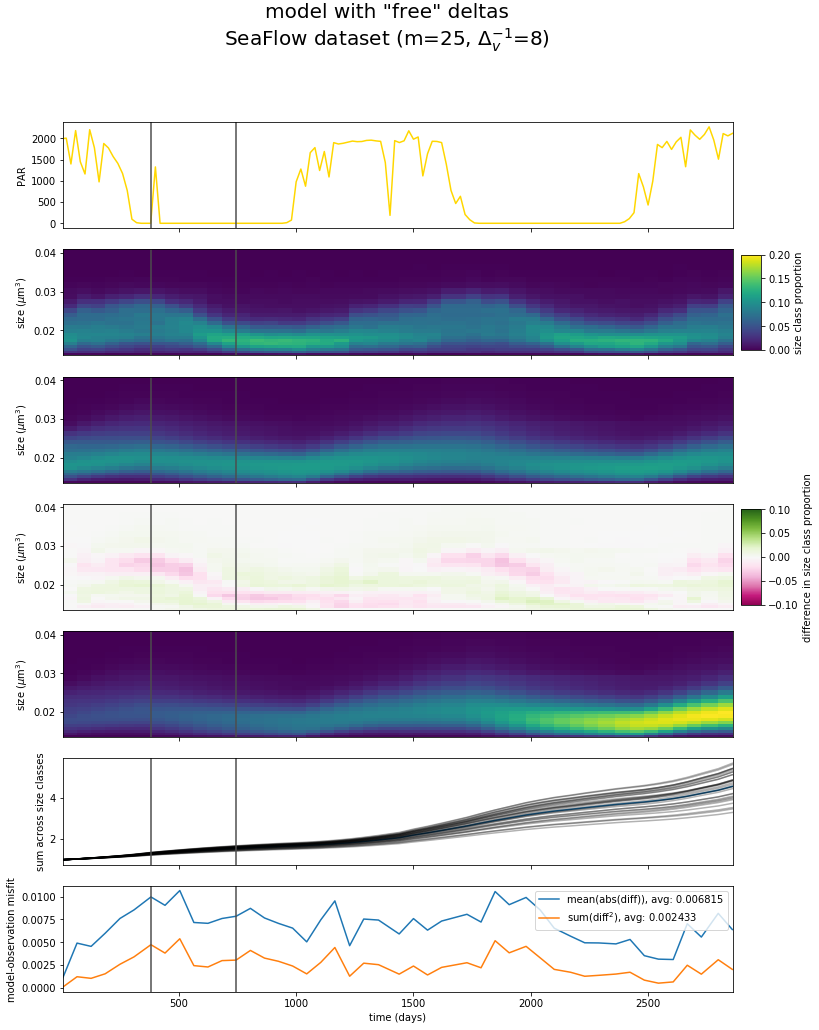

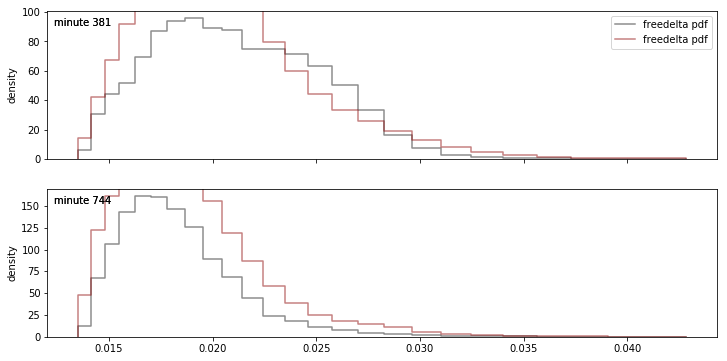

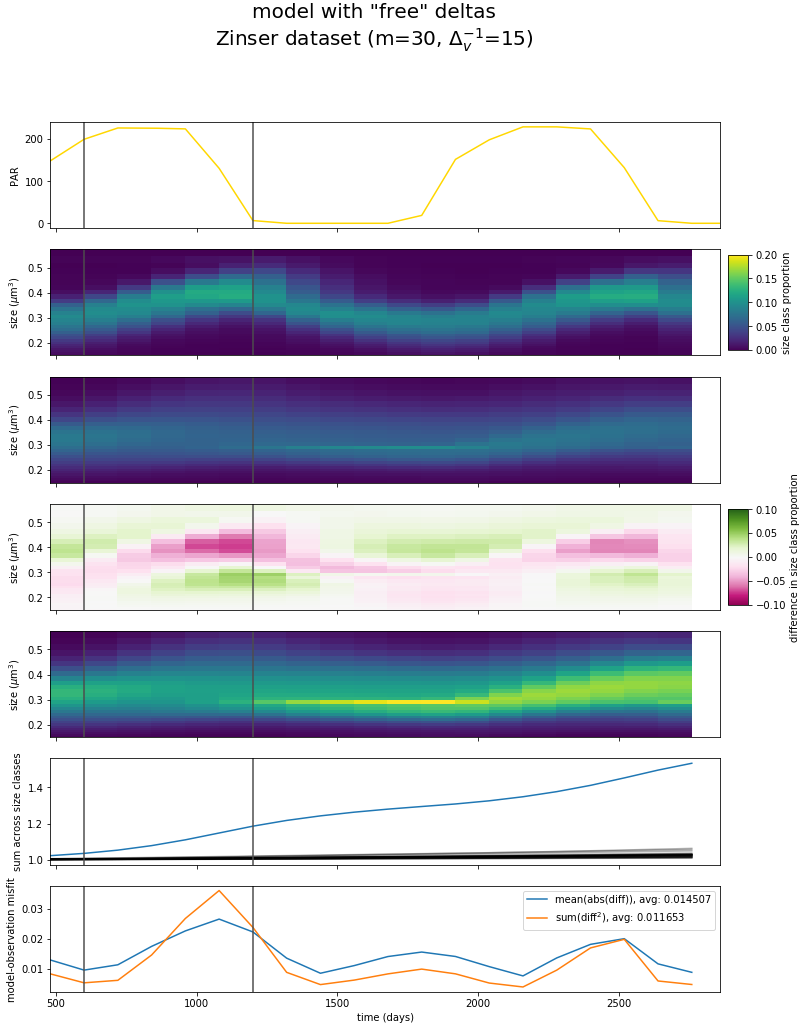

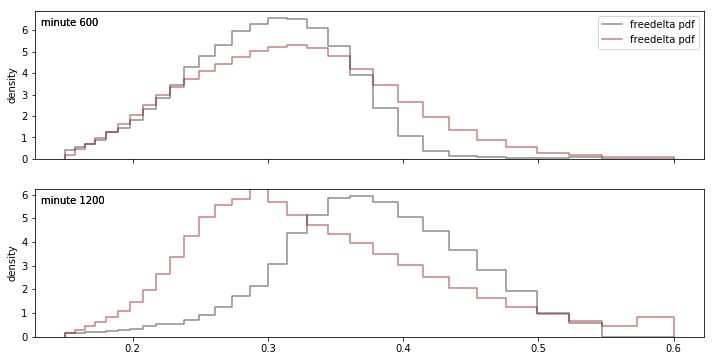

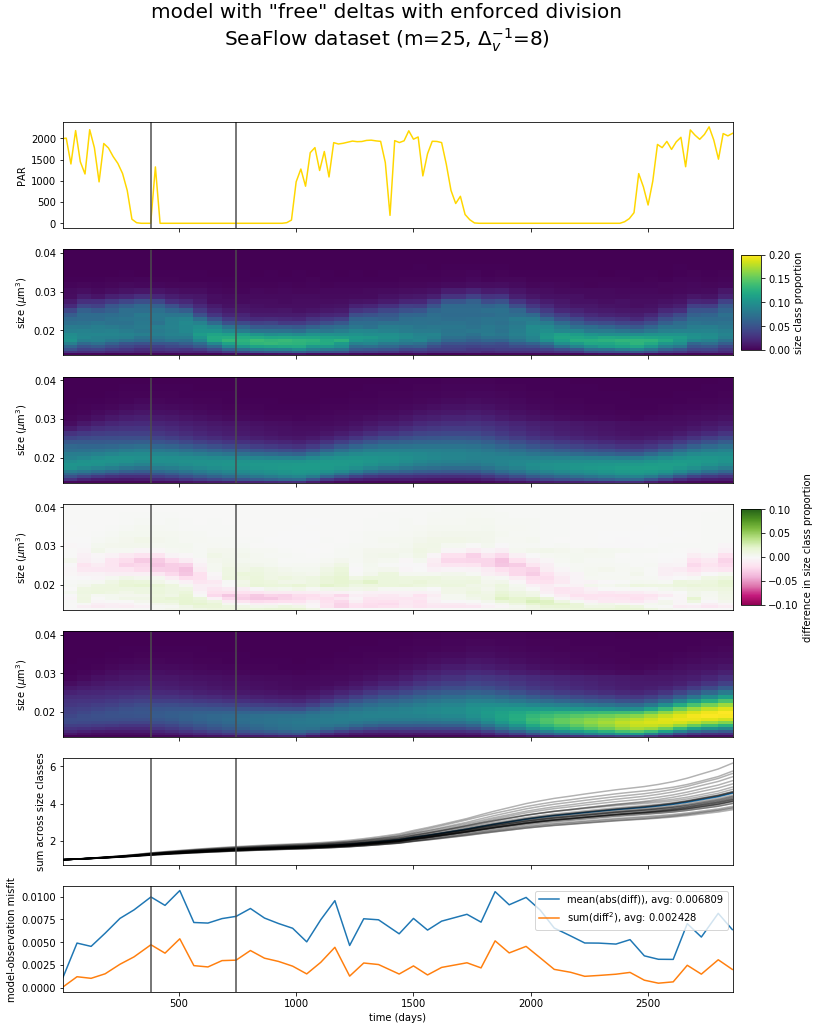

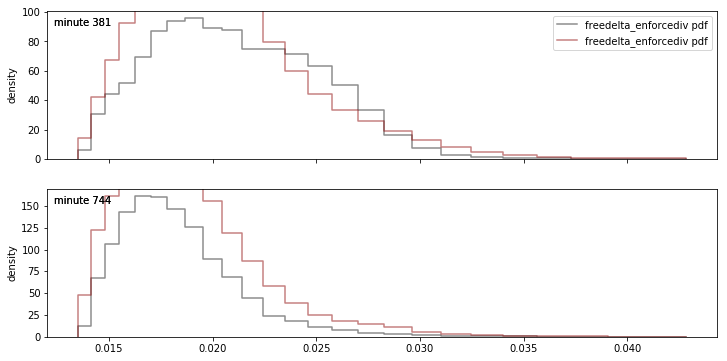

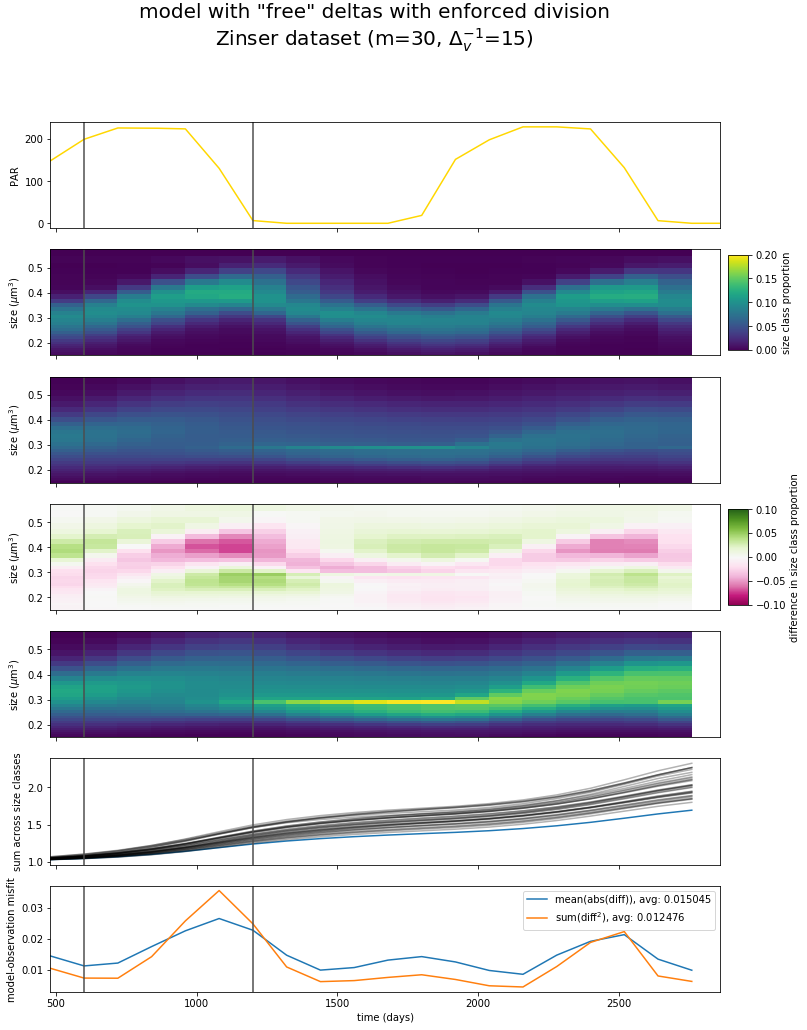

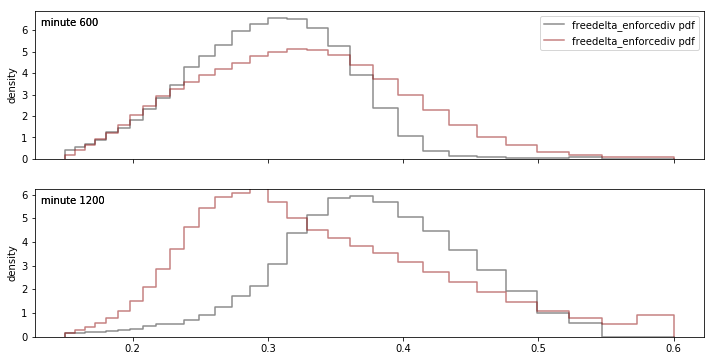

In [7]:
colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for name,mcmc in mcmcs.items():
    for k in data:
        t = data[k]['dt']*np.arange(data[k]['nt'])
        if 'zinser' in k:
            slice_indices = [1,6]
        else:
            slice_indices = [6,12]
        v_ext = data[k]['v_min'] * 2**(np.arange(data[k]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[k]['mod_obspos'], axis=0), 'obs':data[k]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)

        ax = axs[0]
        ax.plot(t, data[k]['E'], color='gold')
        ax.set(xlim=(data[k]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[k]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

        ax = axs[4]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['model'])

        ax = axs[5]
        ax.plot(data[k]['t_obs'], np.sum(res['model'],axis=0))
        ax.plot(data[k]['t_obs'], np.sum(mcmc[k]['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
        ax.set(ylabel='sum across size classes')

        ax = axs[6]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[k]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[k]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (days)', ylabel='model-observation misfit')
        ax.legend()

        for ax in axs.flat:
            for i in slice_indices:
                ax.axvline(data[k]['t_obs'][i], color='.3')

        # plot slices

        plotdata_y = np.zeros(2*(data[k]['m']+1))

        fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
        for i,ax in zip(slice_indices,axs.flat):
            for key in ('obs','model'):
                color = colors[key]
                cdata = res[key][:,i]
                plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
                ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
                ax.text(0.01, 0.95, 'minute {}'.format(data[k]['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
                ax.set_ylabel('density')
                ax.set_ylim(bottom=0.0)
        axs[0].legend()
        None

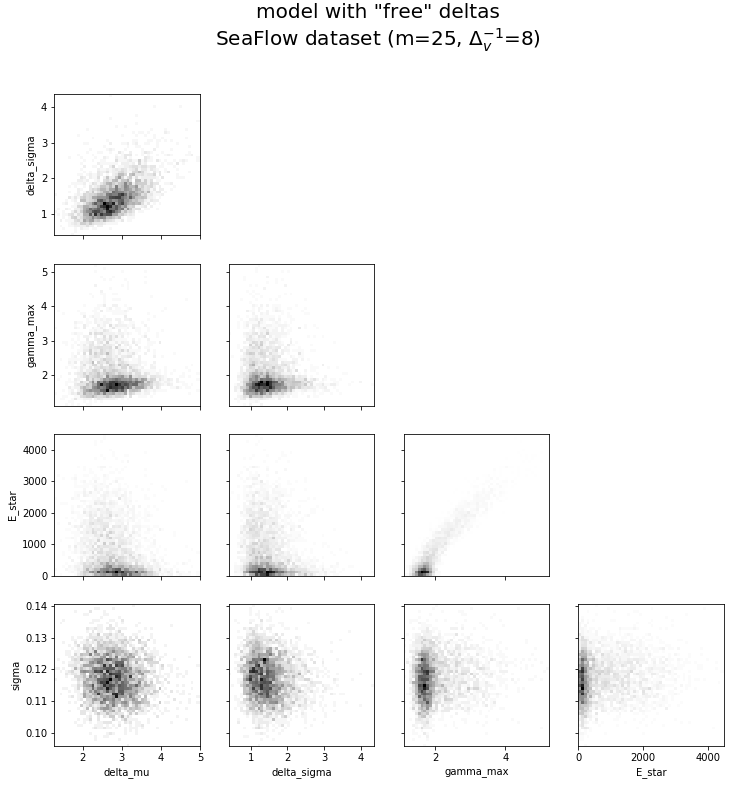

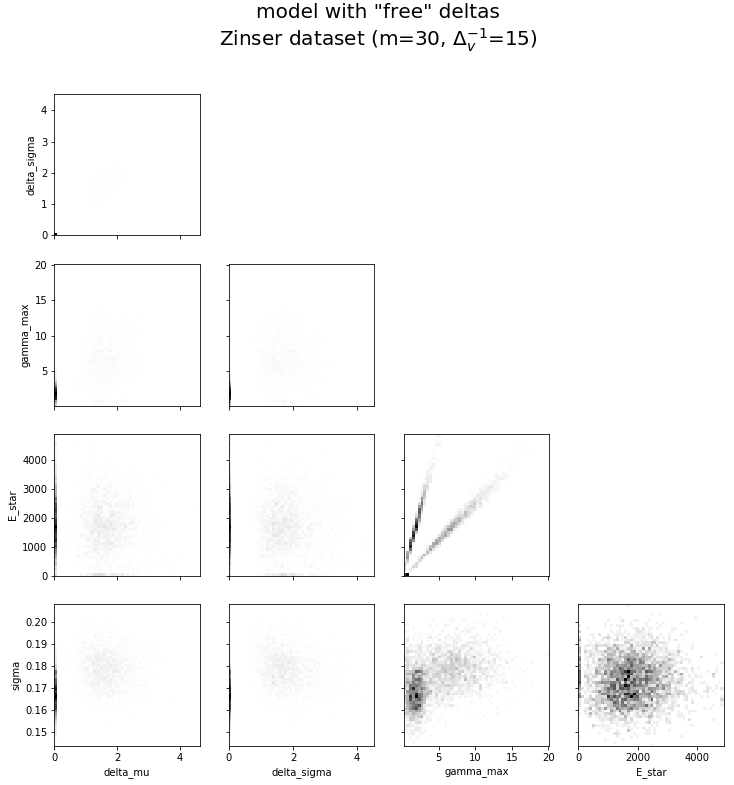

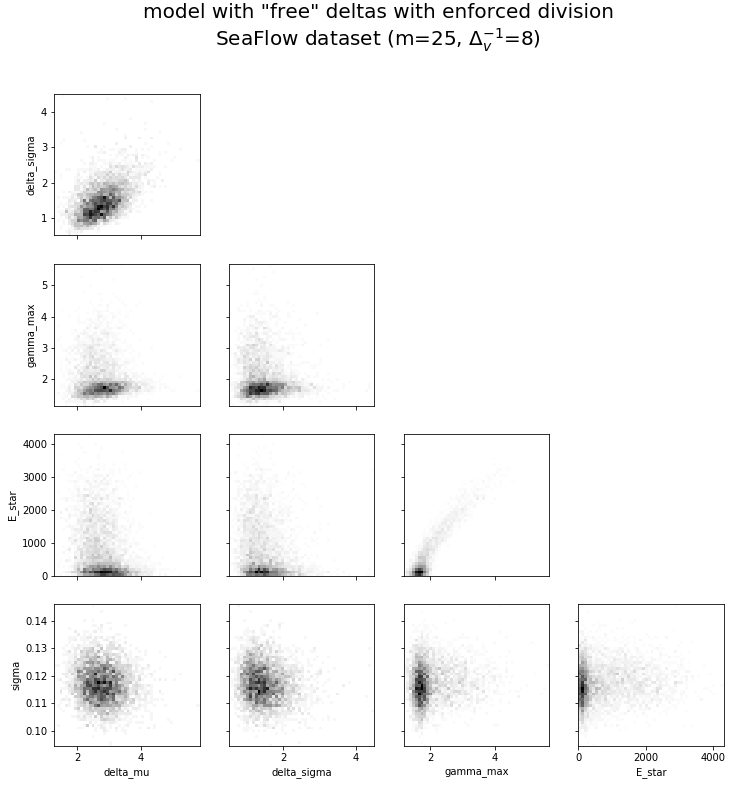

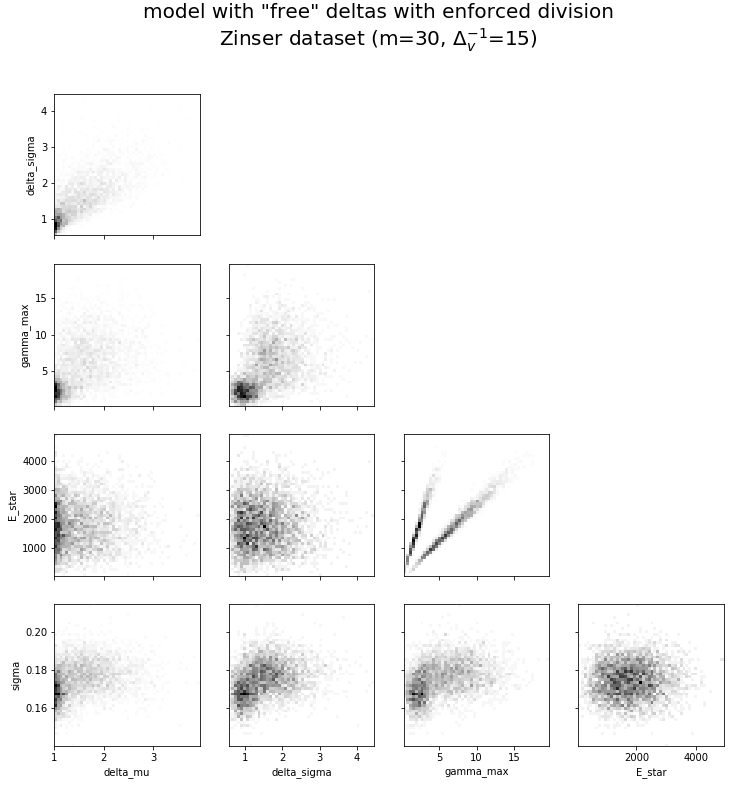

In [8]:
for name,mcmc in mcmcs.items():
    for k in data:
        paramnames = [v for v in mcmc[k].flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max')]
        num_params = len(paramnames)

        fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        for ax in axs.flat:
            ax.set_visible(False)
        for irow in range(1,num_params):
            for icol in range(irow):
                ax = axs[irow-1,icol]
                ax.set_visible(True)
                xname = paramnames[icol]
                yname = paramnames[irow]
                ax.hist2d(mcmc[k][xname],mcmc[k][yname],bins=50,cmap=mpl.cm.gray_r)
                if icol == 0:
                    ax.set_ylabel(yname)
                if irow == num_params-1:
                    ax.set_xlabel(xname)

In [9]:
sig_quantiles = {}

for name in models:
    if 'sigdelta' in name: 
        sig_quantiles[name] = {}
        for k in data:
            m = data[k]['m']
            v_min = data_gridded[k]['v_min']
            delta_v = 1.0/data_gridded[k]['delta_v_inv']
            v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
            num_samples = mcmc[name][k]['sig_offset'].shape[0]
            tmp = np.full((num_samples,m), fill_value=np.nan)
            for i in range(num_samples):
                tmp[i,:] = mcmc[name][k]['delta_max'][i]/(1.0+np.exp(-mcmc[name][k]['sig_steepness'][i]*(v-mcmc[name][k]['sig_offset'][i])))

            sig_quantiles[name][k] = np.percentile(tmp, q=(5,25,50,75,95), axis=0)

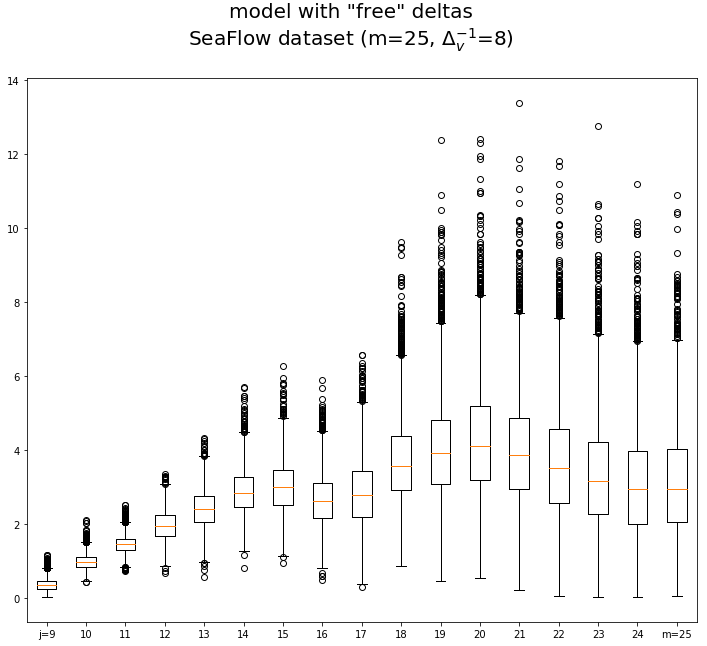

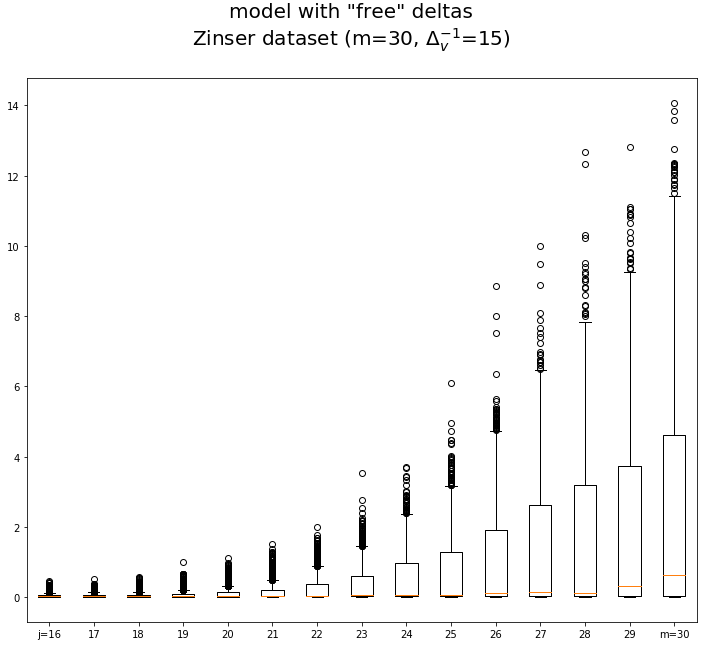

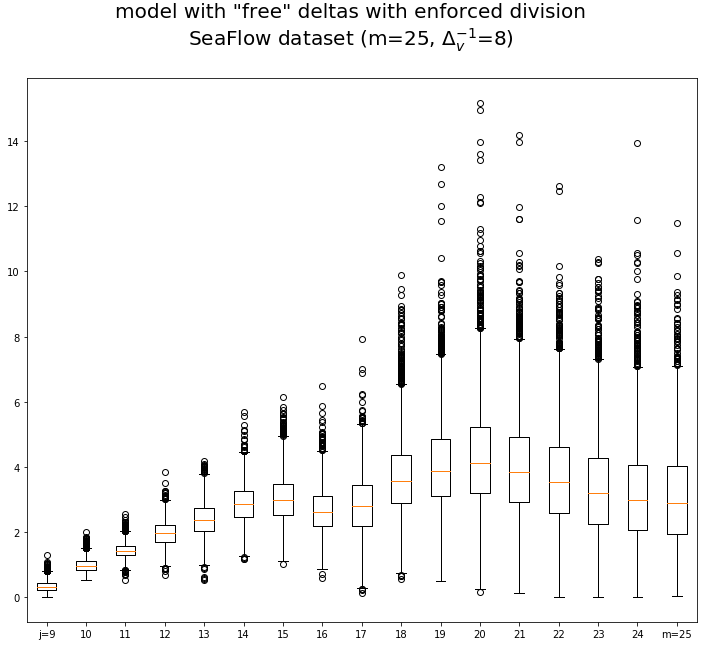

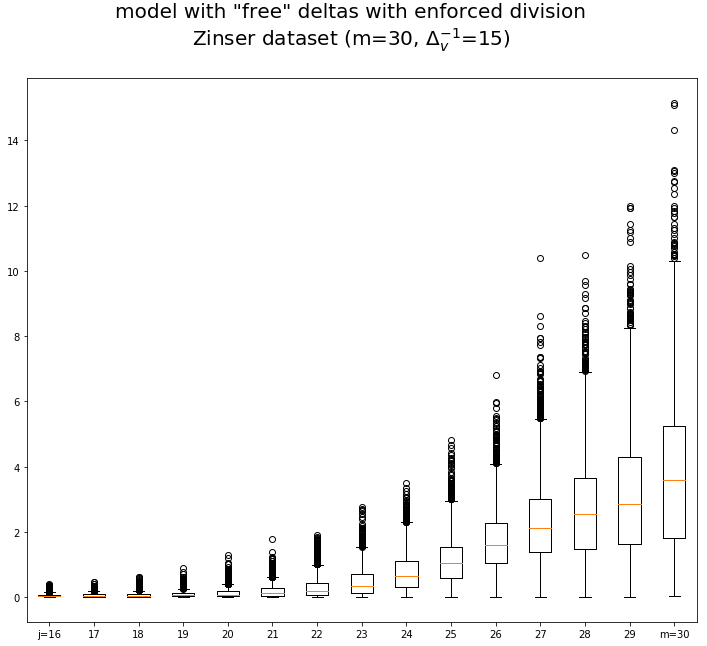

In [10]:
for name,mcmc in mcmcs.items():
    for k in data:
        if 'delta_max[2]' in mcmc[k].flatnames:
            j = data_gridded[k]['delta_v_inv'] + 1
            m = data_gridded[k]['m']
    
            fig, ax = plt.subplots(figsize=(12,10))
            fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
            ax.boxplot(mcmc[k]['delta_max'])
            xlabels = [str(x) for x in range(j,m+1)]
            xlabels[0] = 'j='+xlabels[0]
            xlabels[-1] = 'm='+xlabels[-1]
            ax.set_xticklabels(xlabels)
        else:
            fig, axs = plt.subplots(nrows=len(sig_quantiles[name]), sharex=True, sharey=True, figsize=(12,18))
            
            v_min = data_gridded[k]['v_min']
            delta_v = 1.0/data_gridded[k]['delta_v_inv']
            v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v)

            fig, ax = plt.subplots(figsize=(12,10))
            fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
            ax.fill_between(x=v, y1=sig_quantiles[name][k][0,:], y2=sig_quantiles[name][k][-1,:], alpha=0.25, color='C0')
            ax.fill_between(x=v, y1=sig_quantiles[name][k][1,:], y2=sig_quantiles[name][k][-2,:], alpha=0.5, color='C0')
            ax.plot(v, sig_quantiles[name][k][2,:], color='C0')

            qq = np.percentile(mcmc[name][k]['sig_offset'], q=(5,25,50,75,95))
            ax.axvspan(qq[0], qq[-1], color='darkred', alpha=0.25)
            ax.axvspan(qq[1], qq[2], color='darkred', alpha=0.5)
            ax.axvline(qq[2], color='darkred')
            for vi in v:
                ax.axvline(vi, color='.5', alpha=0.5)
None

In [11]:
sizelim_quantiles = {}
for name,mcmc in mcmcs.items():
    sizelim_quantiles[name] = {}
    for k in data:
        m = data[k]['m']
        v_min = data_gridded[k]['v_min']
        delta_v = 1.0/data_gridded[k]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
        num_samples = mcmc[k]['xi'].shape[0]
        
        tmp = np.full((num_samples,m), fill_value=np.nan)
        for i in range(num_samples):
            xi = mcmc[k]['xi'][i]
            if xi > 0:
                vq = v/v[-1]
                sizelim = vq/(xi+vq)
            else:
                vq = 1.0 + (v_min-v)/v[-1]
                sizelim = vq/(vq-xi)
            tmp[i,:] = sizelim

        sizelim_quantiles[name][k] = np.percentile(tmp, q=(5,25,50,75,95), axis=0)
        
        fig, ax = plt.subplots(figsize=(12,10))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        ax.fill_between(x=v, y1=sizelim_quantiles[name][k][0,:], y2=sizelim_quantiles[name][k][-1,:], alpha=0.25, color='C0')
        ax.fill_between(x=v, y1=sizelim_quantiles[name][k][1,:], y2=sizelim_quantiles[name][k][-2,:], alpha=0.5, color='C0')
        ax.plot(v, sizelim_quantiles[name][k][2,:], color='C0')
        ax.set(xlabel='size', ylabel='growth multiplier')
None

ValueError: No parameter xi